# Bootstrap Resampling

**Learning Objectives:** Learn how to use bootstrap resampling to assest the uncertainty in an estimator.

## Imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## 1 Introduction

We have seen how an estimator enables to you use observed data to work backwards to find the parameters of a model. Estimates produced by an estimators or statistics can have errors for a number of reasons:

1. Wrong model: if the model is wrong, it won't matter how good the estimator is.
1. Bias or variance in the estimator: these are fundamental properties of each estimator.
1. Small number of observations: we have seen that many estimators become more accurate as the number of observations increases.

Bootstrap resampling is a simple and elegant technique for quantifying this last type of uncertainty. To see how this works, let's flip "fair" coins using a Bernuolli distribution $B(p=0.5)$. First, use `numpy.random.choice` to simulate `n` tosses of a fair coin that has values of `H` and `T` with equal probabilities:

In [3]:
m = 100
data = np.random.choice(['H','T'], m, p=[0.5, 0.5])
data

array(['T', 'T', 'H', 'H', 'T', 'H', 'T', 'H', 'H', 'H', 'T', 'T', 'T',
       'T', 'H', 'T', 'H', 'H', 'T', 'T', 'T', 'T', 'H', 'H', 'T', 'T',
       'T', 'T', 'T', 'H', 'T', 'T', 'T', 'T', 'H', 'H', 'H', 'T', 'T',
       'T', 'T', 'T', 'T', 'T', 'T', 'H', 'H', 'T', 'H', 'T', 'H', 'T',
       'T', 'T', 'T', 'T', 'T', 'T', 'H', 'H', 'H', 'T', 'T', 'H', 'T',
       'T', 'T', 'H', 'H', 'H', 'H', 'H', 'H', 'T', 'T', 'T', 'T', 'T',
       'T', 'H', 'H', 'T', 'T', 'H', 'T', 'H', 'T', 'H', 'H', 'H', 'H',
       'T', 'T', 'H', 'T', 'T', 'H', 'H', 'H', 'T'], 
      dtype='<U1')

Next we create an estimator (for $p$) that that computes the ratio of the number of `H` values to the total number of values:

In [4]:
def fair(data):
    """Compute the fraction of the tosses that have a value of `H`."""
    value_counts = {k: v for (k,v) in zip(*np.unique(data, return_counts=True))}
    return value_counts.get('H',0.0)/sum(v for k,v in value_counts.items())

Let's test this estimator:

In [5]:
assert fair(np.array(['H','H','T','T']))==0.5
assert fair(np.array(['T','T','T','T']))==0.0
assert fair(np.array(['H','H','H','T']))==0.75
assert fair(np.array(['H','H','H','H']))==1.0

And compute the estimator from the data:

In [6]:
fair(data)

0.40999999999999998

Now we get to the main idea of bootstrap resampling.

How do we answer the basic question: "is our coin fair?" We are asking if $p$ is "close enough" to $0.5$ for us to call it "fair". If we still had access to the coin, we could continue to flip it and see if the estimator converged to $0.5$. For the simple case of a coin, it is reasonable to think we might still have access to the coin and could keep flipping it until we were satisfied. However, in many, if not most situations, we won't have the ability to observe additional data. So, what to do?

Bootstrap resampling comes to the rescue with the following idea:

**Instead of observing entirely new data, create new datasets by sampling (with replacement) from the existing observed data.**

This is simple to do with `np.random.choice`:

In [7]:
data2 = np.random.choice(data, size=len(data))
data2

array(['H', 'T', 'T', 'H', 'T', 'T', 'T', 'T', 'H', 'T', 'T', 'T', 'T',
       'T', 'H', 'H', 'H', 'H', 'T', 'H', 'H', 'H', 'H', 'H', 'T', 'T',
       'H', 'T', 'T', 'H', 'H', 'T', 'T', 'H', 'T', 'T', 'T', 'T', 'H',
       'H', 'T', 'T', 'H', 'T', 'T', 'T', 'H', 'H', 'H', 'H', 'T', 'H',
       'T', 'T', 'T', 'T', 'H', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T',
       'T', 'T', 'H', 'H', 'H', 'T', 'T', 'H', 'H', 'T', 'H', 'H', 'H',
       'H', 'T', 'H', 'T', 'H', 'T', 'T', 'T', 'T', 'H', 'H', 'T', 'T',
       'H', 'T', 'T', 'H', 'H', 'T', 'T', 'T', 'H'], 
      dtype='<U1')

And let's compute the estimator for this resampled data:

In [8]:
fair(data2)

0.41999999999999998

Notice, that it is slightly different! This small difference gives us a sense of the uncertainty in our estimate. Let's put this basic operation into a function:

In [9]:
def bootstrap_data(data):
    """Perform a single boostrap resampling of the input data array.
    
    Returns an array of the same size as the original.
    """
    return np.random.choice(data, size=data.shape[0])

Some tests for this function:

In [10]:
test_data = np.random.randint(10, size=10)
test_data_re = bootstrap_data(test_data)
assert test_data.shape==test_data_re.shape
for element in test_data_re:
    assert element in test_data

Now let's use this to resample the data a bunch of times and compute the fairness for each resampled data:

In [11]:
for i in range(20):
    re_data = bootstrap_data(data)
    print(fair(re_data))

0.4
0.41
0.34
0.39
0.4
0.4
0.4
0.44
0.32
0.37
0.35
0.42
0.46
0.45
0.38
0.42
0.38
0.37
0.37
0.46


The second idea in bootstrap resampling is this:

**The uncertainy in the estimator can be quantified by studying the distribution of bootstrapped values.***

To make this analysis easier, create a function that can compute an estimator for `n` resampled versions of an input array:

In [12]:
def bootstrap_function(data, f, n):
    """Compute an estimator on data bootstrapped n times.
    
    Parameters
    ----------
    data: ndarray
        The input data to be resampled.
    f: function(data)
        The function to be applied to the boostrapped data. The function should take a single
        argument (the data) and return a float.
    n: int
        The number of times to resample the data
        
    Returns
    -------
    result: ndarray
        An n element array of the values of the function applied to the resampled data.
    """
    result = np.empty(n, dtype=float)
    for i in range(n):
        data2 = bootstrap_data(data)
        result[i] = f(data2)
    return result

Tests for our function:

In [13]:
test_data = np.array([0,0,0,0,1,1,1,1])
fb = bootstrap_function(test_data, lambda data: 1.0, 10)
assert np.allclose(fb, np.array(10*[1.0]))
fb = bootstrap_function(test_data, lambda data: data.mean(), 10)
assert fb.mean()<1.0 and fb.mean()>0.0

Now use `bootstrap_function` to apply the `fair` function to `200` bootstrapped versions of the original data above to compute the bootstrapped distribution of coin fairness.

In [14]:
fairs = bootstrap_function(data, fair, 200)

Here is the result:

In [15]:
fairs

array([ 0.55,  0.41,  0.44,  0.37,  0.37,  0.45,  0.39,  0.38,  0.36,
        0.35,  0.45,  0.4 ,  0.37,  0.29,  0.47,  0.46,  0.48,  0.39,
        0.4 ,  0.44,  0.38,  0.42,  0.39,  0.46,  0.38,  0.38,  0.38,
        0.4 ,  0.38,  0.44,  0.38,  0.46,  0.35,  0.36,  0.5 ,  0.5 ,
        0.41,  0.49,  0.44,  0.42,  0.49,  0.43,  0.45,  0.41,  0.45,
        0.48,  0.44,  0.43,  0.45,  0.45,  0.42,  0.47,  0.48,  0.41,
        0.49,  0.41,  0.45,  0.38,  0.46,  0.42,  0.44,  0.43,  0.45,
        0.35,  0.32,  0.47,  0.48,  0.41,  0.41,  0.54,  0.47,  0.5 ,
        0.33,  0.44,  0.34,  0.42,  0.4 ,  0.43,  0.47,  0.29,  0.41,
        0.42,  0.31,  0.46,  0.47,  0.48,  0.45,  0.32,  0.42,  0.36,
        0.49,  0.42,  0.46,  0.41,  0.35,  0.46,  0.47,  0.37,  0.42,
        0.46,  0.44,  0.43,  0.38,  0.38,  0.4 ,  0.35,  0.31,  0.5 ,
        0.33,  0.42,  0.41,  0.42,  0.4 ,  0.5 ,  0.41,  0.39,  0.36,
        0.5 ,  0.41,  0.45,  0.42,  0.36,  0.49,  0.43,  0.37,  0.39,
        0.44,  0.46,

Now visualize the bootstrapped fairness distribution using a hisogram:

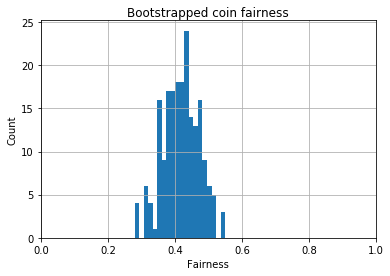

In [16]:
plt.hist(fairs, bins=20)
plt.xlim(0, 1.0)
plt.title("Bootstrapped coin fairness")
plt.xlabel("Fairness")
plt.grid(True)
plt.ylabel("Count");

The distribution is peaked near 0.5 (fair coin), but it a finite variance indicating the uncertainty in the fairness. What do we do with this distribution? There are a couple of options:

1. Just show the distribution and tell people that it represents the uncertainty in the estimator.
2. Compute confidence intervals.

For completeness, let's compute the mean and 95% confidence interval for the fairness using `np.percentile`:

In [17]:
print("Mean fairness:", fairs.mean())
print("95% confidence interval:", np.percentile(fairs, (2.5,97.5)))

Mean fairness: 0.4187
95% confidence interval: [ 0.31     0.51025]


This confidence interval tells us that if we could continue to collect more and more truly new observations, the fairness would be in the interval $[0.42, 059]$ with a confidence of 95 percent. We also have a nice estimate of the bias and variance of the estimator:

In [19]:
bias = fairs.mean() - fair(data)
var = fairs.var()
bias, var

(0.0086999999999999855, 0.0028313100000000001)